# Pandas 라이브러리를 활용해 화재 현황 분석
국내에서 일어난 최근 5년동안의 화재 기록을 pandas를 통해 분석하고 화재 유형별 빈도수와 피해 규모와 그 사이의 연관성을 분석합니다.

## 파일 불러오기

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
# prompt: 디렉토리 "korea_fire_data" 안에 있는 csv 파일들을 Pandas 라이브러리를 통해 읽어들이고 싶어 -> gemini를 이용하여 기본 코드 생성

import pandas as pd
import os
import re

# 연도 순서대로 데이터프레임들을 재정렬하기 위한 이름에서 연도 추출하기 함수
def extract_year(filename):
    match = re.search(r'(\d{4})', filename)
    if match:
        return int(match.group(1))
    return 0  # 년도 정보가 없는 경우 0 반환

# 디렉토리 경로 설정
directory_path = "Korea_Fire"

# 디렉토리 내의 모든 CSV 파일 목록 가져오고 연도별로 정렬
csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
csv_files.sort(key=extract_year)


# 각 CSV 파일을 읽어들여 데이터프레임 목록에 저장 {년도 : 년도에 해당하는 데이터프레임}
dataframes = {}
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    try:
        df = pd.read_csv(file_path, encoding='cp949')  # 인코딩 설정 추가
        dataframes[extract_year(file)] = df
    except pd.errors.ParserError as e:
        print(f"Error parsing {file}: {e}")
    except FileNotFoundError as e:
        print(f"File not found: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while reading {file}: {e}")

dataframes[2020].head(5)

,화재발생년월일,시도,시군구,화재유형,발화열원대분류,발화열원소분류,발화요인대분류,발화요인소분류,최초착화물대분류,최초착화물소분류,인명피해(명)소계,사망,부상,재산피해소계,장소대분류,장소중분류,장소소분류
0,2020-01-01 00:03,전라북도,익산시,"건축,구조물","불꽃, 불티","기타(불꽃,불티)",부주의,기타(부주의),"침구,직물류","기타(침구,직물류)",0,0,0,171,생활서비스,음식점,"치킨,족발"
1,2020-01-01 00:33,서울특별시,성북구,기타(쓰레기 화재등),"담뱃불, 라이터불",담뱃불,부주의,담배꽁초,"종이,목재,건초등",종이,0,0,0,326,기타,야외,쓰레기
2,2020-01-01 00:35,경상북도,영덕군,기타(쓰레기 화재등),"담뱃불, 라이터불",담뱃불,부주의,담배꽁초,기타,기타,0,0,0,0,기타,야외,기타야외
3,2020-01-01 00:40,충청북도,옥천군,"자동차,철도차량",작동기기,"불꽃, 스파크, 정전기",기계적 요인,"과열, 과부하","자동차,철도차량,선박,항공기",오일류,0,0,0,2640,"자동차,철도차량",자동차,승용자동차
4,2020-01-01 00:59,부산광역시,금정구,"자동차,철도차량",미상,미상,미상,미상,미상,미상,0,0,0,7904,"자동차,철도차량",자동차,오토바이


## 1. 화재의 피해규모 분포 ( 인명피해 / 재산피해 )
모든 사고별 인명피해/재산피해가 얼마나 큰 지 전수조사한뒤 이 분포도를 시각화합니다.

a. 인명피해 분포도

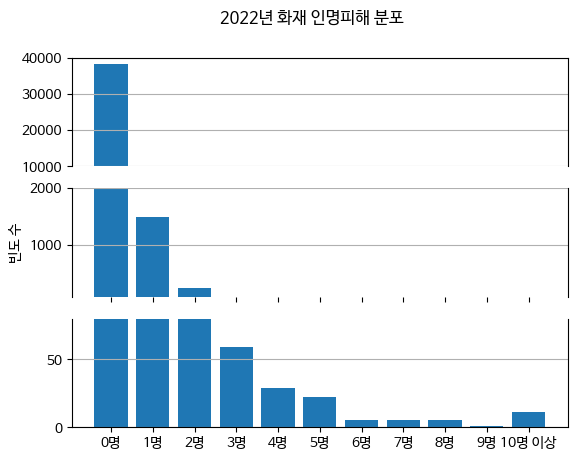

In [3]:
# prompt: dataframes[2022]의 인명피해가 어떻게 분포되어있는지 데이터화하고 이를 시각화한 자료로 나타내고 싶어

import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumBarunGothic')

if '인명피해(명)소계' in dataframes[2022].columns:
    # 인명피해(명)소계 값의 빈도 계산
    injuries_counts = dataframes[2022]['인명피해(명)소계'].value_counts().sort_index()
    ranged_counts = pd.Series()
    above10 = 0

    for index, value in injuries_counts.items():
      if index >= 10:
        above10 = above10 + value
      else:
        ranged_counts[str(index) + "명"] = value

    ranged_counts["10명 이상"] = above10

    # 중간선이 생략되도록 보이는 plot 2개를 만드는 예제

    fig, axs = plt.subplots(ncols=1, nrows=3, sharex=True)
    d = .7    # how big to make the diagonal lines in axes coordinates
    fig.suptitle("2022년 화재 인명피해 분포")
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]

    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    ax1.yaxis.grid()
    ax2.yaxis.grid()
    ax3.yaxis.grid()

    ax1.set_ylim(10000, 40000)
    ax2.set_ylim(80, 2000)
    ax3.set_ylim(0, 80)

    ax2.set_ylabel("빈도 수")

    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(False)

    # f.text(0.02, 0.50, "Encryption time (sec)", va='center', rotation = 'vertical', fontsize = 16)
    ax1.get_xaxis().set_visible(False)

    ax1.bar(ranged_counts.index, ranged_counts.values)
    ax2.bar(ranged_counts.index, ranged_counts.values)
    ax3.bar(ranged_counts.index, ranged_counts.values)

    plt.show()
else:
  print("2022년 데이터에서 '사망자수' 또는 '부상자수' 컬럼을 찾을 수 없습니다. 컬럼명을 확인해주세요")


b. 재산피해 분포도

1억 이상          5115
5000만원~1억      3217
500~5000만원    12706
0~500만원       19075
dtype: int64


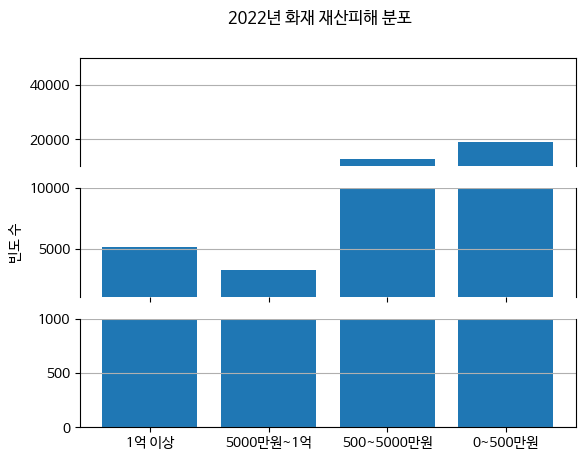

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumBarunGothic')

if '재산피해소계' in dataframes[2022].columns:

    property_damages = dataframes[2022]['재산피해소계']
    ranged_counts = pd.Series({"1억 이상" : 0, "5000만원~1억" : 0, "500~5000만원" : 0, "0~500만원" : 0})

    #0~500만원, 500~5000만원, 5000만원~1억, 1억 이상으로 나누기
    for index, value in property_damages.items():
      if value >= 10000:
        ranged_counts["1억 이상"] = ranged_counts["1억 이상"] + 1
      elif value >= 5000:
        ranged_counts["5000만원~1억"] = ranged_counts["5000만원~1억"] + 1
      elif value >= 500:
        ranged_counts["500~5000만원"] = ranged_counts["500~5000만원"] + 1
      else:
        ranged_counts["0~500만원"] = ranged_counts["0~500만원"] + 1

    print(ranged_counts)

    # 중간선이 생략되도록 보이는 plot 2개를 만드는 예제

    fig, axs = plt.subplots(ncols=1, nrows=3, sharex=True)
    d = .7    # how big to make the diagonal lines in axes coordinates
    fig.suptitle("2022년 화재 재산피해 분포")
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]

    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    ax1.yaxis.grid()
    ax2.yaxis.grid()
    ax3.yaxis.grid()

    ax1.set_ylim(10000, 50000)
    ax2.set_ylim(1000, 10000)
    ax3.set_ylim(0, 1000)

    ax2.set_ylabel("빈도 수")

    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(False)

    # f.text(0.02, 0.50, "Encryption time (sec)", va='center', rotation = 'vertical', fontsize = 16)
    ax1.get_xaxis().set_visible(False)

    ax1.bar(ranged_counts.index, ranged_counts.values)
    ax2.bar(ranged_counts.index, ranged_counts.values)
    ax3.bar(ranged_counts.index, ranged_counts.values)

    plt.show()
else:
  print("2022년 데이터에서 '사망자수' 또는 '부상자수' 컬럼을 찾을 수 없습니다. 컬럼명을 확인해주세요")


결론 1 : 화재는 그 이미지와 달리 대부분의 상황에서 인명 피해보다는 재산 피해의 비중이 횔씬 높으며 다수의 화재사건에서 인명피해는 1명도 발생하지 않는다. 그에 비해 재산피해는 0~5억원대의 데이터로 고루 분포해 있었으며 1억 이상의 중대한 재산피해가 발생하는 비율도 꽤 높은 것으로 나타났다.

## 2. 화재의 여러 지표들과 피해 규모의 연관성 검증



이때 궁금증이 생긴다. 그렇다면 피해 규모는 화재의 어떤 지표와 관련이 있을까?
화재의 유형을 결정짓는 4가지 대분류인 "발화열원대분류", "장소대분류", "발화요인대분류", "최초착화물대분류"가 대형사고의 비중에 얼마나 영향을 미치는지 분석한다.

인명피해는 유의미한 인명피해라고 여겨지는 명수인 5명 이상인 사건
재산피해는 유의미한 재산피해라고 여겨지는 최소 50억원 이상인 사건
인 사건을 대형화제로 규정한다.

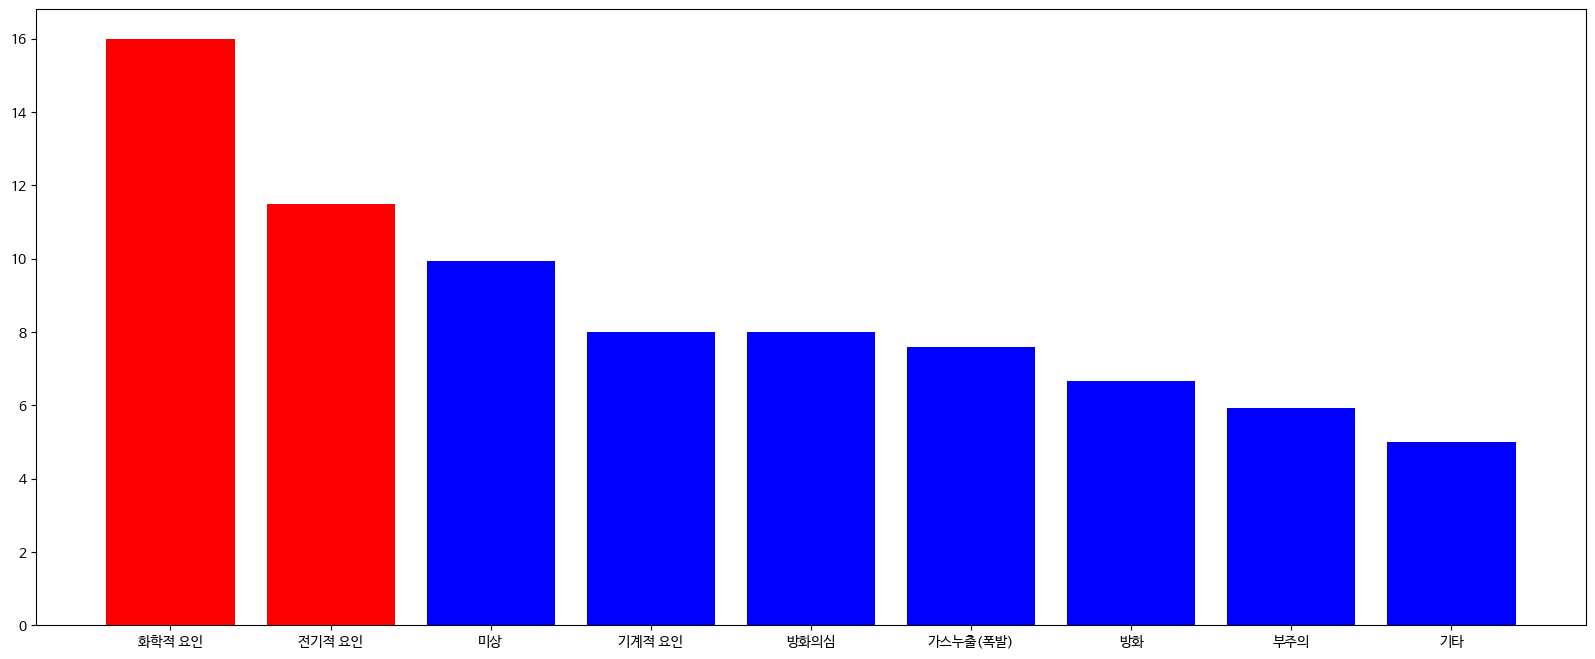

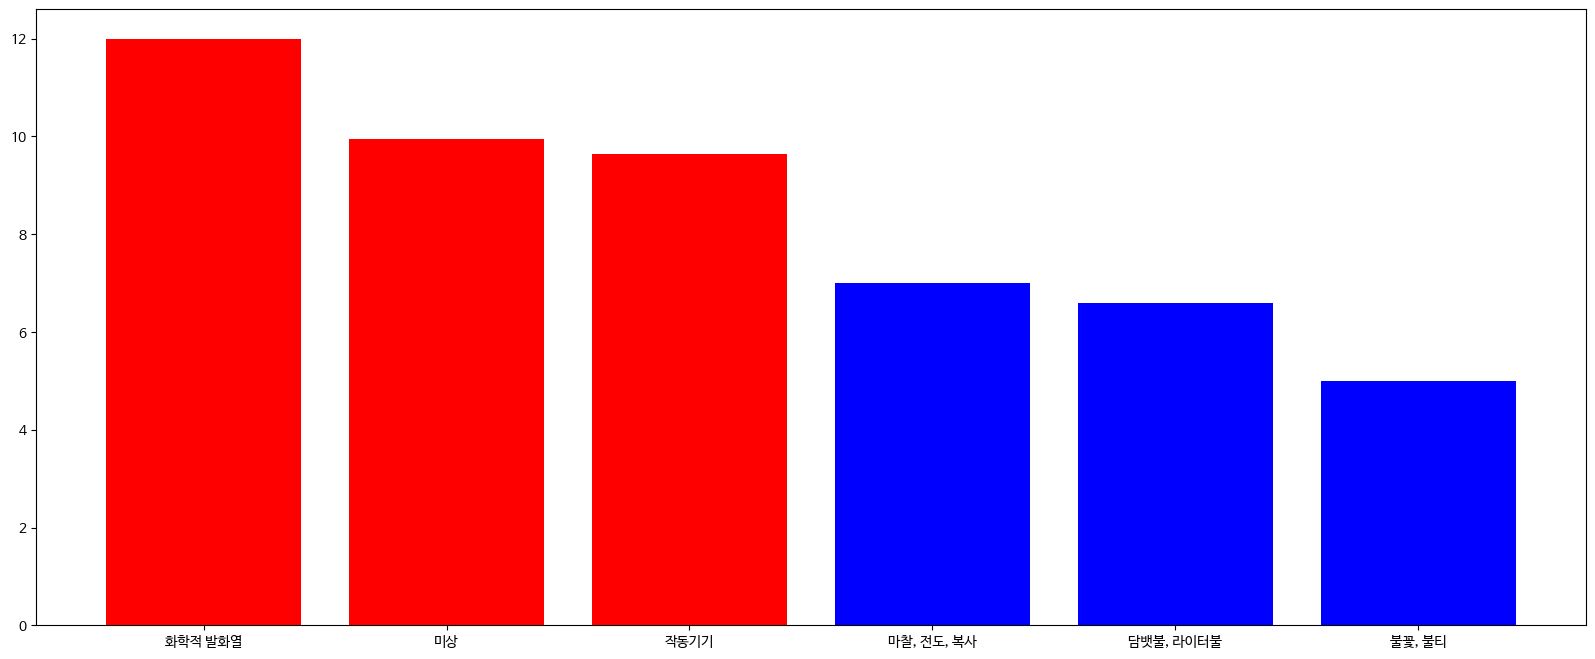

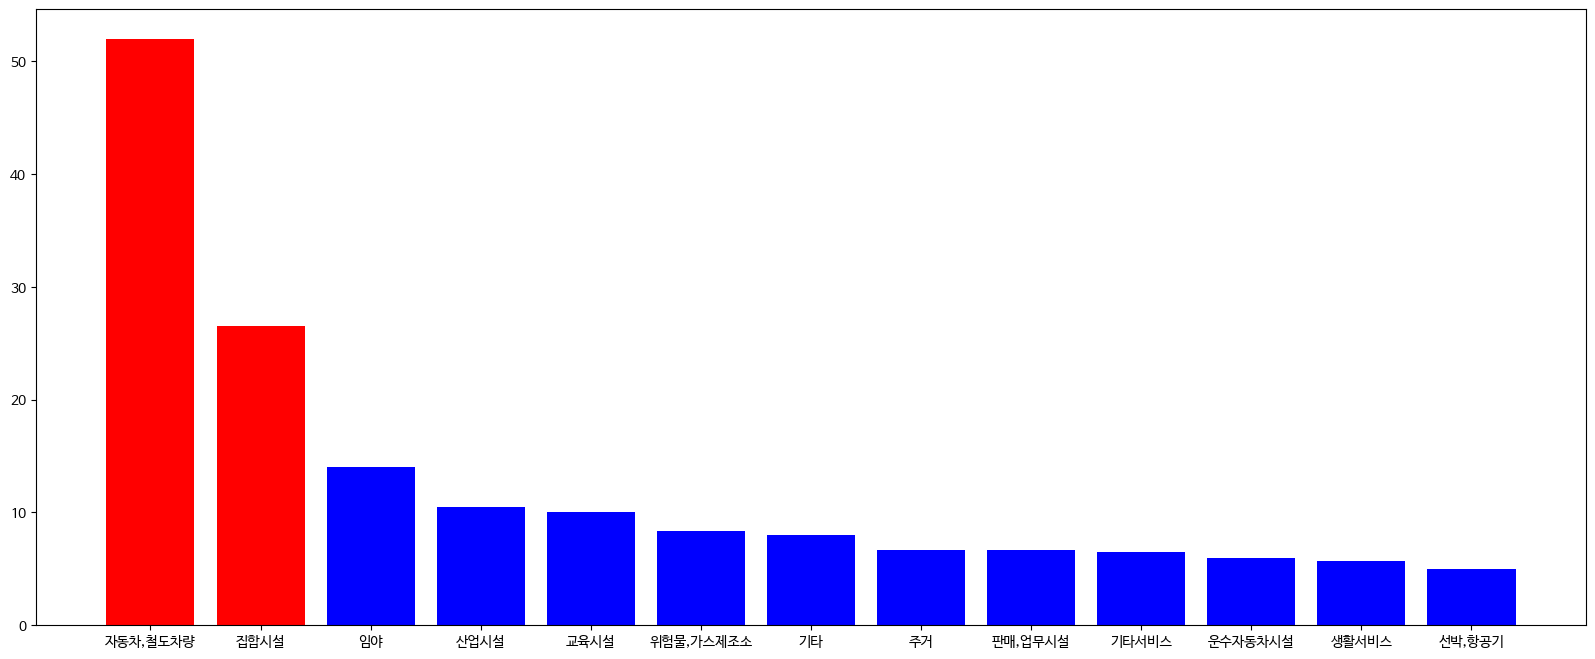

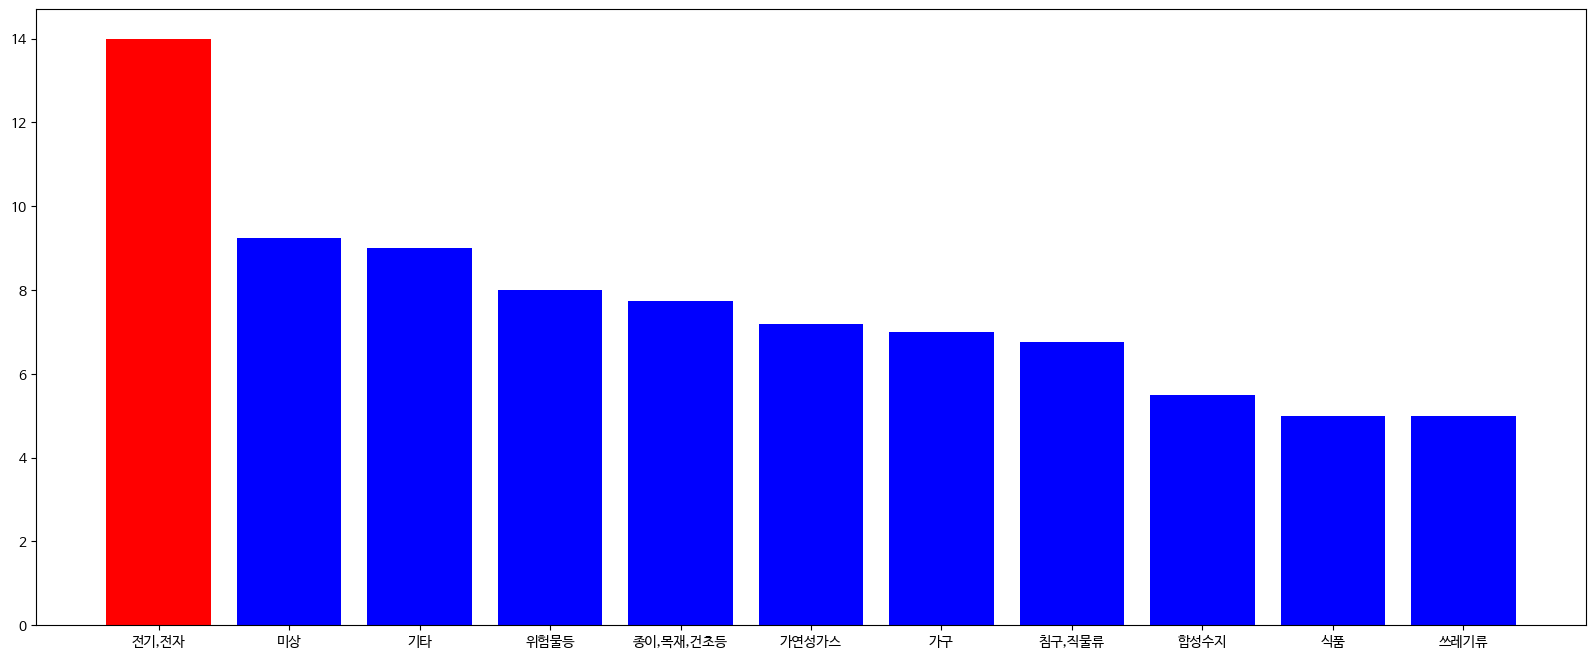

In [89]:
# prompt: dataframesp[2022]의 '인명피해(명)소계' 열이 5 이상 되는 인덱스만 남긴 Death_dataframe 새로운 데이터 프레임으로 만들고 싶어
def filter_values(df, key, indexsArr):
  for value in df[key].value_counts().index:
    indexsArr.append(value)

def make_series(df, key, indexsArr):
  indexsArr_dict = {}
  for words in indexsArr:
    value = df[df[key] == words]['인명피해(명)소계'].mean()
    indexsArr_dict[words] = value

  return pd.Series(indexsArr_dict)

def emphasize_highvalue(sr, cutline):
  result_colors = []
  for data in sr.index:
    if sr[data] >= cutline:
      result_colors.append("red")
    else:
      result_colors.append("blue")
  return result_colors

# 인명피해가 5명 이상 발생한 대형 화재사고를 요인에 따라 분리하고 요인에 따른 규모 상관관계 도출
Death_dataframe = dataframes[2022][dataframes[2022]['인명피해(명)소계'] >= 5]

# 각 항목 발화요인대분류 12항목, 발화열원대분류 9항목, 장소대분류 14항목, 최초착화물대분류 13항목
IgnitionFactors = []
IgnitionSources = []
Places = []
FirstFireMaterials = []

filter_values(Death_dataframe, '발화요인대분류', IgnitionFactors)
filter_values(Death_dataframe, '발화열원대분류', IgnitionSources)
filter_values(Death_dataframe, '장소대분류', Places)
filter_values(Death_dataframe, '최초착화물대분류', FirstFireMaterials)

# 해당 키를 바탕으로 요소별 평균 인명피해량 딕셔너리 ~ 시리즈화

IgnitionFactors_Series = make_series(Death_dataframe, '발화요인대분류', IgnitionFactors).sort_values(ascending=False)
IgnitionSources_Series = make_series(Death_dataframe, '발화열원대분류', IgnitionSources).sort_values(ascending=False)
Places_Series = make_series(Death_dataframe, '장소대분류', Places).sort_values(ascending=False)
FirstFireMaterials_Series = make_series(Death_dataframe, '최초착화물대분류', FirstFireMaterials).sort_values(ascending=False)

# 발화요인대분류에 따른 평균 인명피해량 그래프 만들기

plt.figure(figsize=(20,8))
plt.bar(x=IgnitionFactors_Series.index, height=IgnitionFactors_Series.values, color=emphasize_highvalue(IgnitionFactors_Series, 10))
plt.show()

plt.figure(figsize=(20,8))
plt.bar(x=IgnitionSources_Series.index, height=IgnitionSources_Series.values, color=emphasize_highvalue(IgnitionSources_Series, 9))
plt.show()

plt.figure(figsize=(20,8))
plt.bar(x=Places_Series.index, height=Places_Series.values, color=emphasize_highvalue(Places_Series, 20))
plt.show()

plt.figure(figsize=(20,8))
plt.bar(x=FirstFireMaterials_Series.index, height=FirstFireMaterials_Series.values, color=emphasize_highvalue(FirstFireMaterials_Series, 10))
plt.show()

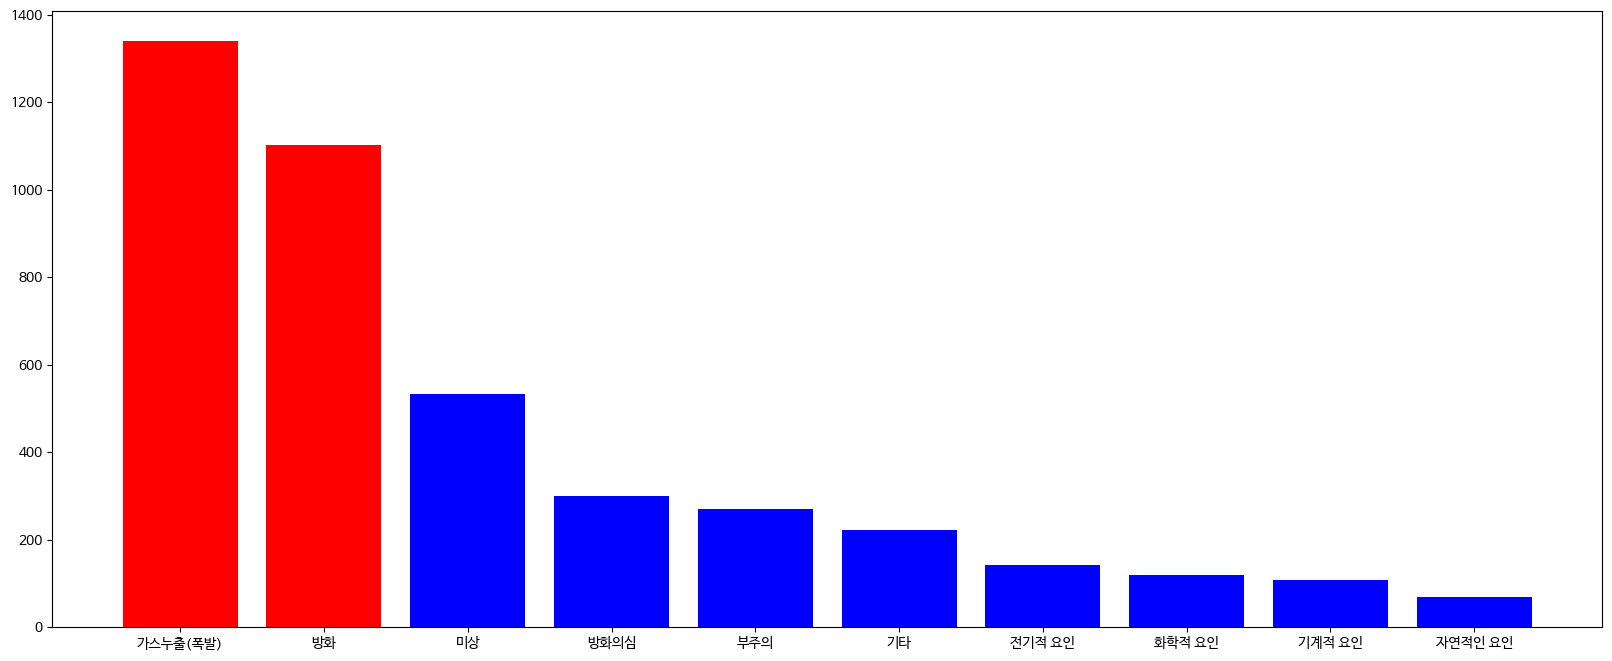

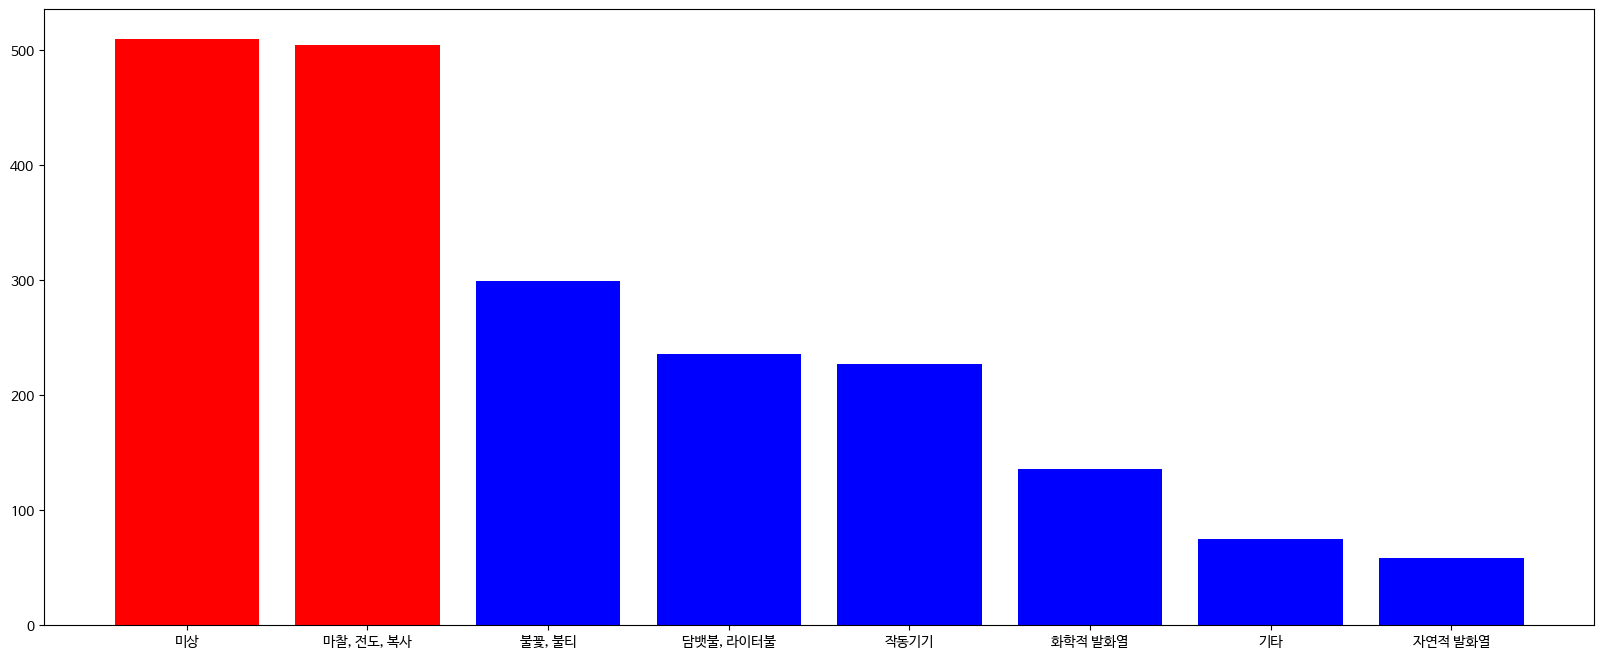

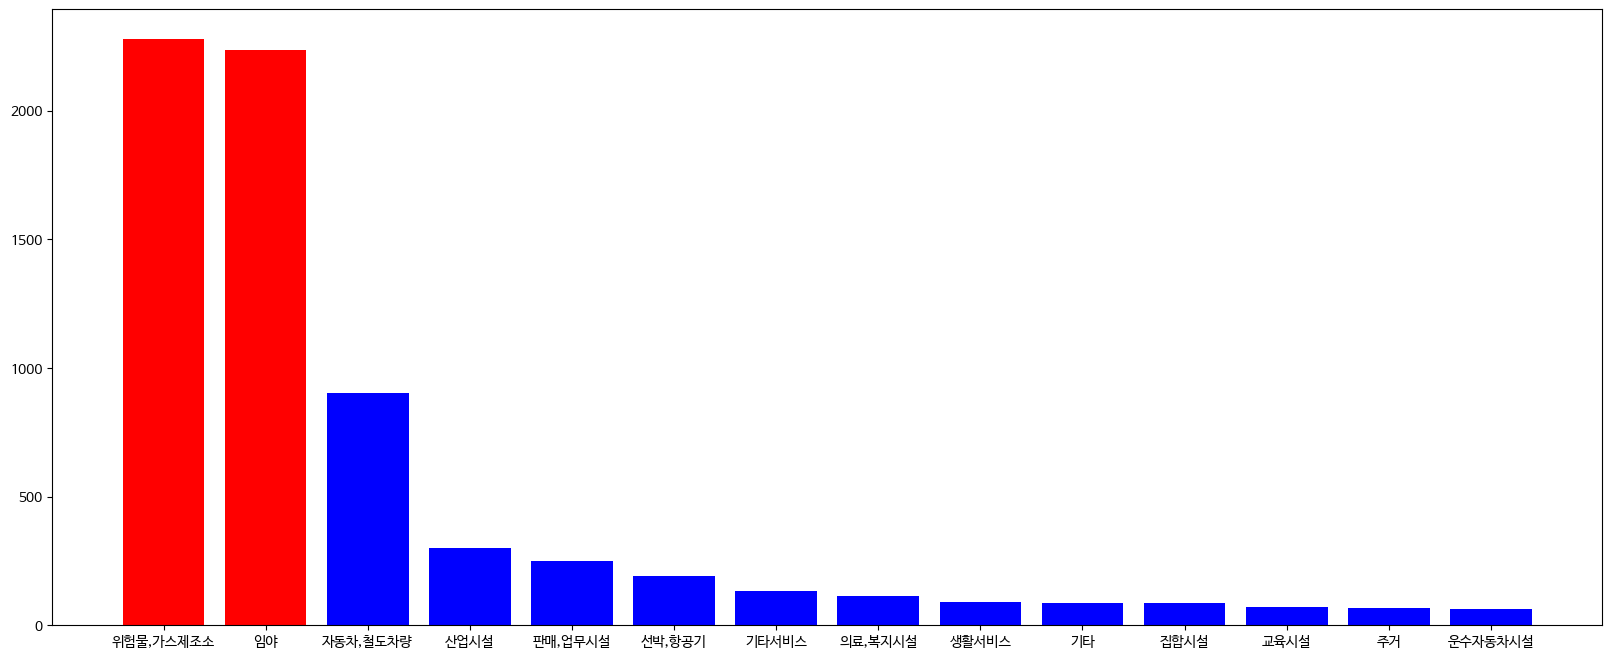

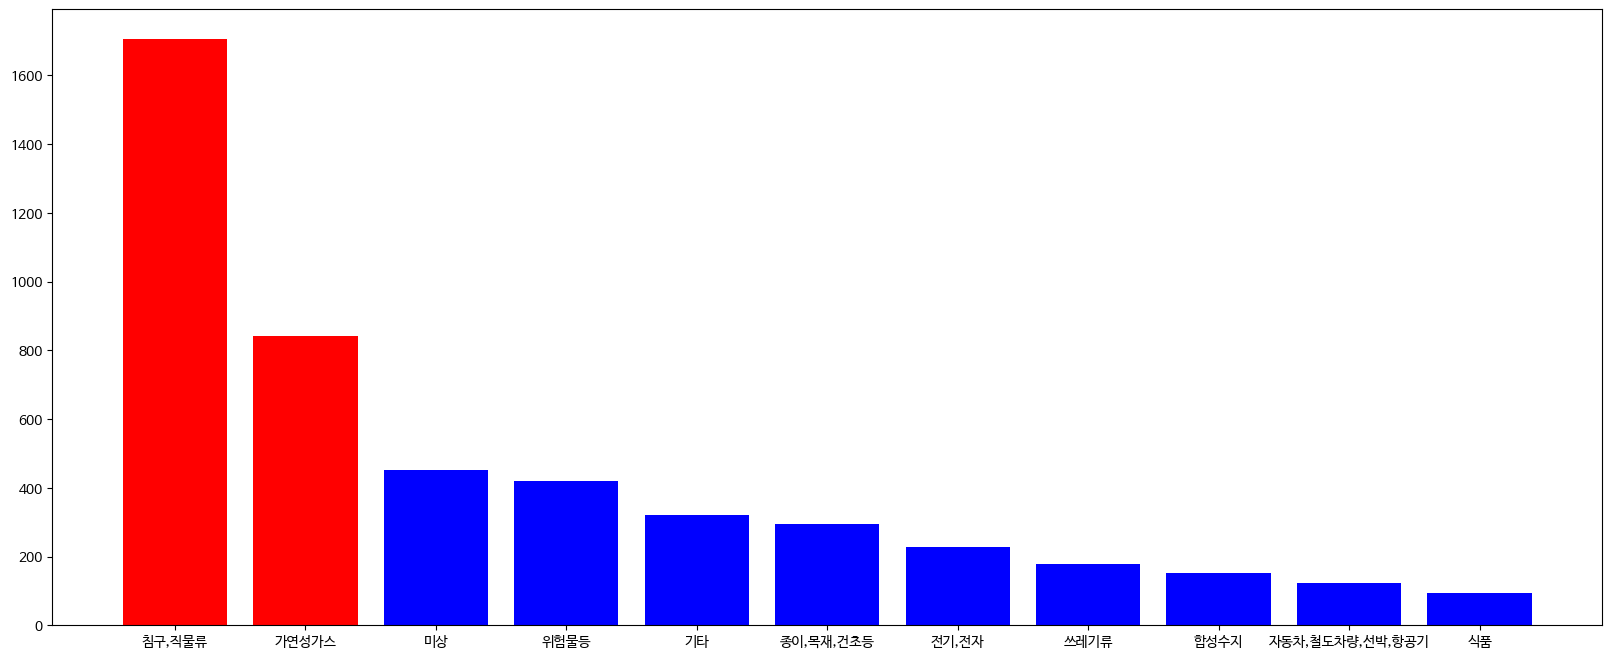

In [97]:
def make_series(df, key, indexsArr):
  indexsArr_dict = {}
  for words in indexsArr:
    value = df[df[key] == words]['재산피해소계'].mean()
    indexsArr_dict[words] = value

  return pd.Series(indexsArr_dict)

# 재산 피해가 50억 이상 발생한 대형 화재사고를 요인에 따라 분리하고 요인에 따른 규모 상관관계 도출
Money_dataframe = dataframes[2022][dataframes[2022]['재산피해소계'] >= 500000]

# 각 항목 발화요인대분류 12항목, 발화열원대분류 9항목, 장소대분류 14항목, 최초착화물대분류 13항목
IgnitionFactors = []
IgnitionSources = []
Places = []
FirstFireMaterials = []

filter_values(Money_dataframe, '발화요인대분류', IgnitionFactors)
filter_values(Money_dataframe, '발화열원대분류', IgnitionSources)
filter_values(Money_dataframe, '장소대분류', Places)
filter_values(Money_dataframe, '최초착화물대분류', FirstFireMaterials)

# 해당 키를 바탕으로 요소별 평균 인명피해량 딕셔너리 ~ 시리즈화

IgnitionFactors_Series = make_series(Money_dataframe, '발화요인대분류', IgnitionFactors).sort_values(ascending=False)
IgnitionSources_Series = make_series(Money_dataframe, '발화열원대분류', IgnitionSources).sort_values(ascending=False)
Places_Series = make_series(Money_dataframe, '장소대분류', Places).sort_values(ascending=False)
FirstFireMaterials_Series = make_series(Money_dataframe, '최초착화물대분류', FirstFireMaterials).sort_values(ascending=False)

# 발화요인대분류에 따른 평균 인명피해량 그래프 만들기

plt.figure(figsize=(20,8))
plt.bar(x=IgnitionFactors_Series.index, height=IgnitionFactors_Series.values/10000, color=emphasize_highvalue(IgnitionFactors_Series, 1000*10000))
plt.show()

plt.figure(figsize=(20,8))
plt.bar(x=IgnitionSources_Series.index, height=IgnitionSources_Series.values/10000, color=emphasize_highvalue(IgnitionSources_Series, 300*10000))
plt.show()

plt.figure(figsize=(20,8))
plt.bar(x=Places_Series.index, height=Places_Series.values/10000, color=emphasize_highvalue(Places_Series, 1000*10000))
plt.show()

plt.figure(figsize=(20,8))
plt.bar(x=FirstFireMaterials_Series.index, height=FirstFireMaterials_Series.values/10000, color=emphasize_highvalue(FirstFireMaterials_Series, 600*10000))
plt.show()

### 분석 결과 (인명피해)

- 인명피해가 5명 이상인 사고들 기준, 대형화재의 '평균 피해 규모'를 나타낸다. *(빈도가 아님!)* 여기서 ()로 표시되는 값은 편의상 정수 단위로 근사하여 분석한다.
  *   **발화요인** : 화학적 요인(16), 전기적 요인(12)에 의한 피해가 큰 것으로 나타났다. 그 다음으로 규모가 큰 기계적 요인(8)보다 약 50~100% 큰 수치다.
  *   **발화열원** : 화학적 발화열(12), 작동기기(10)에 의한 화재가 피해가 큰 것으로 나왔다. 그 다음으로 규모가 큰 마찰, 전도, 복사(7)보다 약 40~80% 가량 큰 수치다
  *   **장소** : 자동차,철도차량(**55**), 집합시설(**26**)에 의한 화재가 피해가 큰 것으로 나왔다. 그다음으로 규모가 큰 임야(14)에 비해 180~400% 가량 큰 수치다
  *   **최초 착화물** : 전기,전자(14)에 의한 화재가 피해가 큰 것으로 나왔다. 그 다음으로 규모가 큰 위험물등(8)에 비해 약 75%가량 큰 것으로 나타났다.



### 분석 결과 (재산피해)

- 재산 피해가 50억 이상인 사고들 기준, 여기서 ()로 표시되는 값은 편의상 100자리로 근사하여 계산한다
  *   **발화요인** : 가스누출(폭발)(1300), 방화(1100)에 의한 화재가 피해가 큰 것으로 나왔다. 그 다음으로 규모가 큰 부주의(300)에 비해 약 3배인 수치다
  *   **발화열원** : 마찰, 전도, 복사(500)에 의한 화재가 피해가 큰 것으로 나왔다. 그 다음으로 규모가 불꽃, 불티(300)에 비해 약 1.6배인 수치다.
  *   **장소** : 위험물, 가스제조소(**2300**), 임야(**2300**)에 의한 화재가 피해가 큰 것으로 나왔다. 그다음으로 규모가 큰 자동차, 철도차량(700)에 비해 약 3배인 수치다.
  *   **최초 착화물** : 침구,직물류(1700), 가연성 가스(800)에 의한 화재가 피해가 큰 것으로 나왔다. 그 다음으로 규모가 큰 위험물등(400)에 비해 약 2~4배인 수치다.

## 3. 결론

a. 공통, 인명피해와 재산피해 모두 공통적으로 보이는 피해 규모 면에서의 특징은 다음과 같다.
  - 장소가 피해 규모에 매우 크게 작용한다.
  
  (인명피해의 경우 가장 큰 피해 규모를 가지는 다른 발화원들의 평균 인명피해량이 10~20명에서 그치는데 비해 장소는 특정 장소에서 26, 50명이 평균 인명피해량으로 나온다. 이는 인명피해에 있어 장소가 큰 영향을 미친다는 의미이다.)
  
  (재산피해 역시 장소가 큰 영향을 미친다. 장소 다음으로 큰 영향을 미치는 최초 착화물이 평균 1700억이고 다른 주요 원인들과도 큰 차이가 나지 않는 데 비해 장소는 둘다 2300억으로 격차가 큰 편이다.)

b. 인명피해 분석에서 나온 분석은 다음과 같다.
  - 발화요인, 발화열원은 지표별로 차이가 크게 차이나지 않았다.
  - 착화물은 장소보단 아니지만 위험한 곳에 착화할 경우 피해 규모가 크게 오른다.
  - 전체적으로 전기적, 화학적 요인이 작용할 때 피해 규모가 커지는 경향이 있다.

c. 재산피해 분석에서 나온 분석은 다음과 같다.
  - 인명피해와 다르게 가스누출과 관련된 분야에서 피해 규모가 커지는 경향이 있다.
  - 침구,직물류가 최초 착화물인 화재의 규모가 크게 나온 게 특이하다.
  - 인명피해에 비해 피해 규모를 크게 늘리는 요인들이 분명하다.

d. 알수있는 점
  - 화재에 취약한 장소는 다른 요인들보다 더 큰 피해의 요인이 되므로 화재 방비 인프라를 효율적으로 방비하고자 할 때 장소를 기준으로 우선순위를 배정할 수 있다.
  - 전기 화학적 요인으로 인한 화재는 인명피해가 큰 경향이 있으므로 화재 발생시 화재의 수습보다 인력의 최대한 빠른 대피와 구조에 무게를 기울일 필요가 있다.
  - 침구류나 직물류 옆에선 특히 불조심하자. 불장난하다 알거지되는 수가 있다.
  - 화재의 가장 주요하고 잦은 원인 (담뱃불, 건조함)이 반드시 피해 규모와 연관되지는 않는다.
